## Evaluate WoFSCast Performance 

In [1]:
# From WoFSCast
from runner import WoFSCastRunner
from plot_params import target_vars, display_name_mapper, units_mapper

# Third-party
import os 
import xarray 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob

import sys
sys.path.append('/home/monte.flora/python_packages/MontePython')
import monte_python
import dask

In [2]:
def replace_zeros(data): 
    return np.where(data==0, 1e-5, data)

class ObjectVerification:
    """
    ObjectVerification computes simple contingency table metrics based on matching 
    objects between prediction and target objects. 
    
    Attributes
    --------------
    object_matcher : An initialized MontePython.ObjectMatcher object. Used for matching 
    the target and prediction object fields. 
    
    """
    def __init__(self, object_matcher): 
        self._object_matcher = object_matcher 

        self.hits_ = 0
        self.false_alarms_ = 0
        self.misses_ = 0 
        
    def update_metrics(self, target, prediction): 
        """ Compute the hits, misses, and false alarms based on the object matching.
        
        TODO: This is not robust for non-one-to-one matching!!
        
        Parameters
        ------------
        target : 2d numpy.ndarray : The labelled target field 
        prediction : 2d numpy.ndarray: The labelled prediction field 
        
        """
        matched_pred, matched_tar, dists = self._object_matcher.match(prediction, target)
    
        n_total_pred_objs = len(np.unique(prediction)[1:]) #[1:] to ignore the 0 label
        n_total_tar_objs = len(np.unique(target)[1:])
    
        n_matched_pred = len(matched_pred)
        n_matched_tar = len(matched_tar)
    
        assert_txt = """Number of matched predictions exceed number of predictions objects"""
        assert n_total_pred_objs >= n_matched_pred , assert_txt
        
        self.hits_ += n_matched_pred 
        self.false_alarms_ += (n_total_pred_objs - n_matched_pred ) 
        self.misses_ += (n_total_tar_objs - n_matched_tar)
    
    def reset_metrics(self):
        """Resets the counts of hits, false alarms, and misses to zero."""
        self.hits_ = 0
        self.false_alarms_ = 0
        self.misses_ = 0
    
    @property
    def pod(self):
        """Hits / Hits + Misses"""
        return self.hits_ / (self.hits_ + self.misses_)
    
    @property
    def sr(self):
        """Hits / Hits + False Alarms"""
        return self.hits_ / (self.hits_ + self.false_alarms_)
    
    @property
    def csi(self):
        """Hits / Hits + Misses + False Alarms"""
        return self.hits_ / (self.hits_ + self.false_alarms_ + self.misses_)
    

In [3]:
#@dask.delayed
def process_time_step(this_pred, this_tar):
    # Identify objects
    labels_pred, pred_object_props = monte_python.label(
        input_data=this_pred['COMPOSITE_REFL_10CM'],
        method='single_threshold', 
        return_object_properties=True, 
        params={'bdry_thresh': 40})

    labels_tar, tar_object_props = monte_python.label(
        input_data=this_tar['COMPOSITE_REFL_10CM'],
        method='single_threshold', 
        return_object_properties=True, 
        params={'bdry_thresh': 40})

    # Quality control
    labels_pred, pred_object_props = qcer.quality_control(
        this_pred['COMPOSITE_REFL_10CM'], labels_pred, pred_object_props, qc_params)

    labels_tar, tar_object_props = qcer.quality_control(
        this_tar['COMPOSITE_REFL_10CM'], labels_tar, tar_object_props, qc_params)

    # Update metrics
    obj_verifier = ObjectVerification(matcher)  # Assuming matcher initialization
    obj_verifier.update_metrics(labels_tar, labels_pred)
    results = {key: getattr(obj_verifier, f"{key}_") for key in ["hits", "false_alarms", "misses"]}
    
    obj_verifier.reset_metrics()
    
    return results



In [7]:
%%time 
# For the time series
MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_baseline_full_v2.npz'
model = WoFSCastRunner(MODEL_PATH)

n_times = 12 

base_path = '/work/mflora/wofs-cast-data/datasets_2hr/2021/*_ens_mem_09.nc'
paths = glob(base_path)
paths.sort()

rs = np.random.RandomState(42)
random_paths = rs.choice(paths, size=2, replace=False)

matcher = monte_python.ObjectMatcher(cent_dist_max = 3, 
                                     min_dist_max = 3, 
                                     time_max=0, 
                                     score_thresh=0.2, 
                                     one_to_one = True)

obj_verifier = ObjectVerification(matcher)
qcer = monte_python.QualityControler()
qc_params = [('min_area', 12)]


n_times = 12 
cont_dict = {metric : np.zeros((n_times)) for metric in ['hits', 'misses', 'false_alarms']}

for path in random_paths: 
    dataset = xarray.load_dataset(path)

    inputs, targets, forcings = model.get_inputs(dataset)
    predictions = model.predict(inputs, targets, forcings)
    predictions = predictions.transpose('batch', 'time', 'level', 'lat', 'lon')

    results = [process_time_step(predictions.isel(time=t, batch=0), targets.isel(time=t, batch=0))
              for t in np.arange(n_times)]
    
    for t, result in enumerate(results):
        for key in cont_dict.keys():
            cont_dict[key][t] += result[key]
        


CPU times: user 11.6 s, sys: 22.6 s, total: 34.2 s
Wall time: 8.65 s


In [8]:
# With Dask: 8.91 s; Without: 8.84s; With mp: 9.3s

## Time Series of POD, SR, CSI 

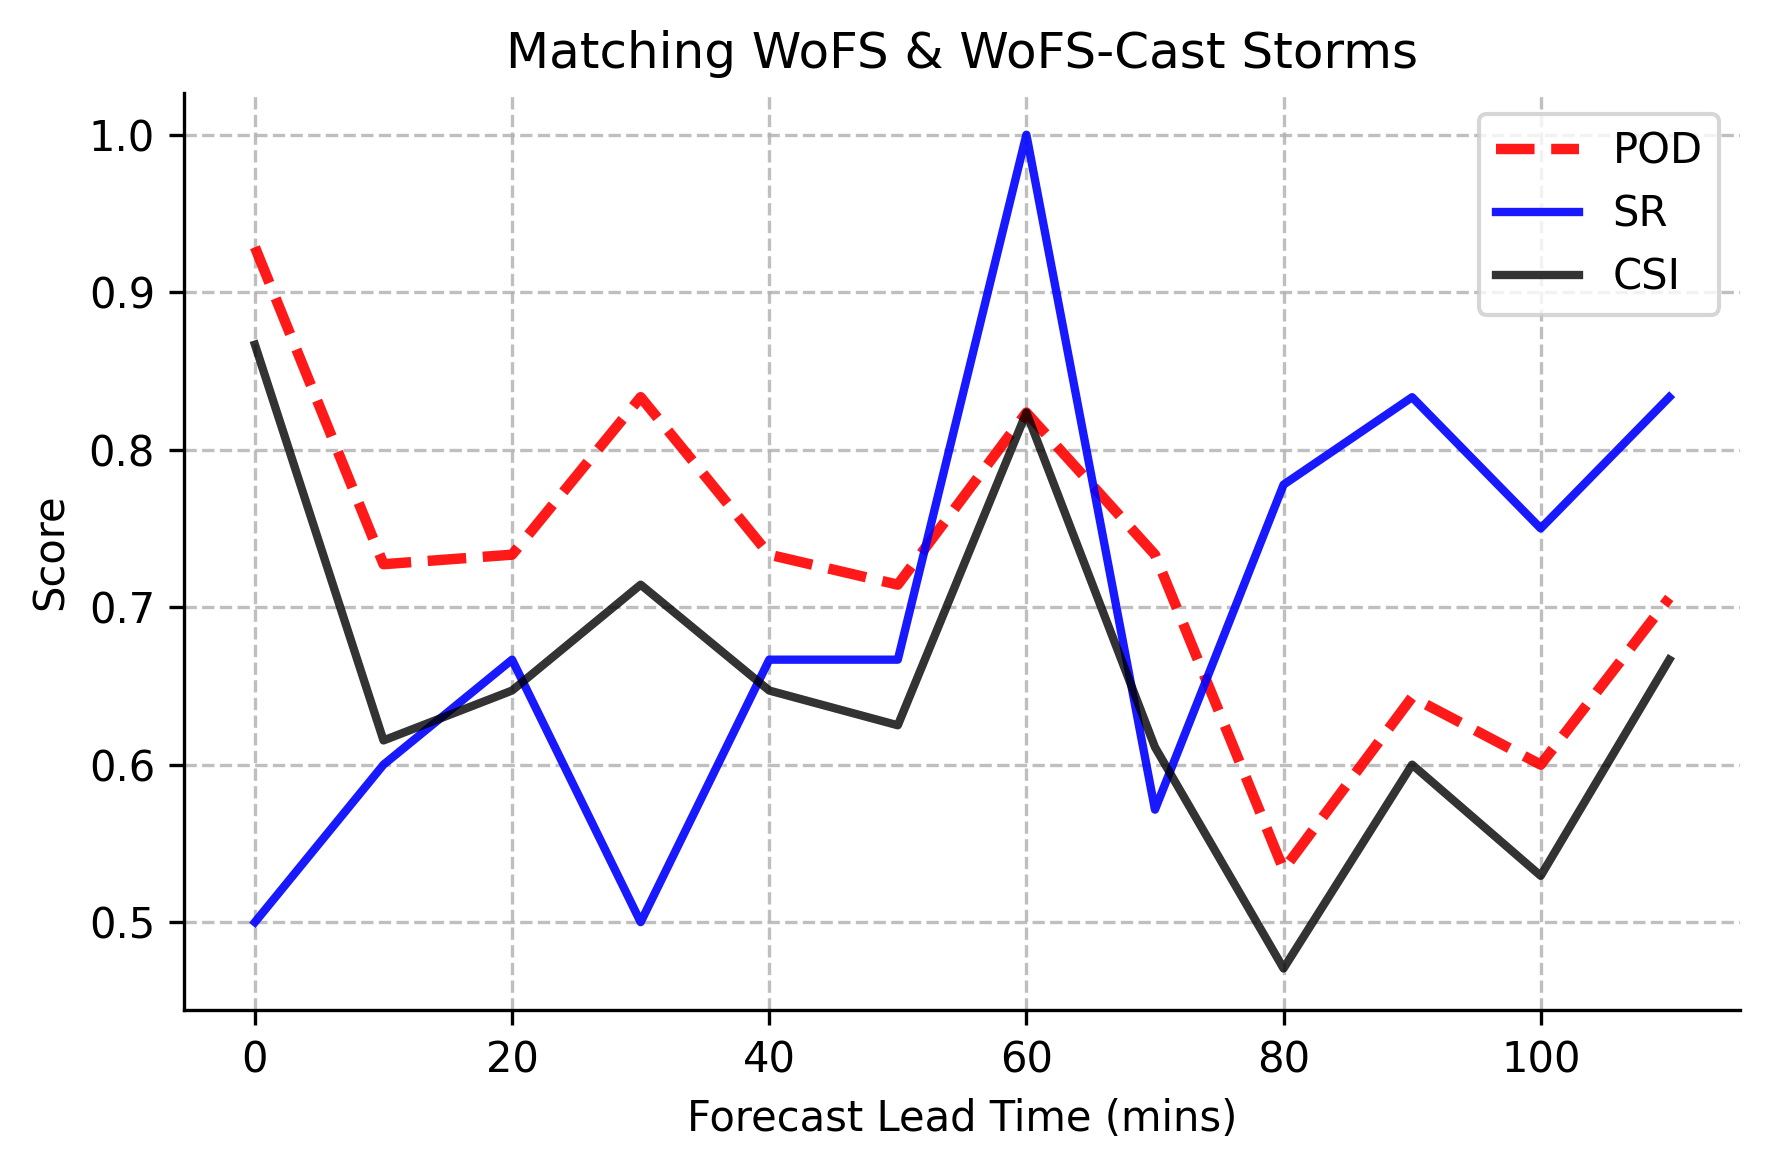

In [9]:
times = np.arange(len(predictions.time))*10 # in minutes 
fig, ax = plt.subplots(figsize=(6,4), dpi=300, )

cont_dict['hits'] = replace_zeros(cont_dict['hits'])
cont_dict['misses'] = replace_zeros(cont_dict['misses'])
cont_dict['false_alarms'] = replace_zeros(cont_dict['false_alarms'])

pod = cont_dict['hits'] / (cont_dict['hits'] + cont_dict['misses'])
sr = cont_dict['misses'] / (cont_dict['misses'] + cont_dict['false_alarms'])
csi = cont_dict['hits'] / (cont_dict['hits'] + cont_dict['misses'] + cont_dict['false_alarms'])

ax.plot(times, pod, label='POD', c='red', ls='dashed', lw=2.5, alpha=0.9)
ax.plot(times, sr, label='SR', c='blue', lw=2.0, alpha=0.9)
ax.plot(times, csi, label='CSI', c='black', lw=2.0, alpha=0.8)

ax.set(xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f"Score", 
       title = 'Matching WoFS & WoFS-Cast Storms'
      )

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
ax.legend()
    
plt.tight_layout()